# Selecting genomes for simulated communities

Samuel Barnett

### Introduction

Here I will be selecting genomes taken from the NCBI RefSeq genome database to get a representative sample for a simulated bacterial community. For this experiment, I need three separate reference genome sets with different G+C skews.

The RefSeq database was downloaded on January 25th, 2019.


## 1) Initialization

First I need to import the python modules I'll use, set some variables, initiate R magic, and create/get into the working directory.

In [1]:
import os
workDir = '/home/sam/data/SIPSim2_data/RealWorld_study3/'
genomeDir = '/home/sam/databases/ncbi_genomes/ncbi-genomes-2019-01-25/'
nprocs = 10

In [2]:
import sys
import pandas as pd
import numpy as np
import ConfigParser


In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(dplyr)
library(ggplot2)

/home/sam/anaconda3/envs/SIPSim2_py2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/envs/SIPSim2_py2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/envs/SIPSim2_py2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


In [5]:
# making directories
## working directory
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

## genome directory
if not os.path.isdir(genomeDir):
    print("Genome directory does not exist!!!")
else:
    print(genomeDir)

/home/sam/data/SIPSim2_data/RealWorld_study3
/home/sam/databases/ncbi_genomes/ncbi-genomes-2019-01-25/


## 2) Select genomes for the community

### Removing references from the same species

In this simulation I want to make sure there is only one reference genome from each species presesent (i.e. no strains). I'll just randomly take a single strain from species that are represented from multiple strains.

[1] 1542
[1] 1491
                                             taxon_name     accession
1                     GCF_000018105.1_ASM1810v1_genomic   NC_009925.1
2                   GCF_002005445.1_ASM200544v1_genomic NZ_CP014692.1
3                   GCF_001766235.1_ASM176623v1_genomic NZ_CP015164.1
4                   GCF_002006565.1_ASM200656v1_genomic NZ_CP014687.1
5 GCF_001499615.1_Acetobacter_senegalensis_108B_genomic NZ_LN606600.1
6                    GCF_000247605.1_ASM24760v1_genomic   NC_016894.1
                   species genome_length GC_percent num_chromosomes
1     Acaryochloris_marina       8361599   46.95589              10
2        Acetobacter_aceti       3725037   56.82929               1
3 Acetobacter_pasteurianus       2999217   53.17291               4
4      Acetobacter_persici       3756676   57.43809               2
5 Acetobacter_senegalensis       3969909   55.64095               2
6    Acetobacterium_woodii       4044777   39.33814               1
                

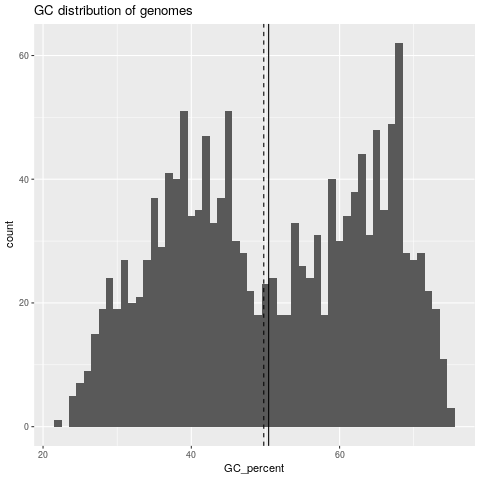

In [6]:
%%R -i genomeDir
genome.stats = read.table(paste(genomeDir, 'genome_stats.txt', sep=""), header=TRUE, sep="\t")

set.seed(7242)
subs.genome.stats = genome.stats %>%
    group_by(species) %>%
    sample_n(1) %>%
    as.data.frame

print(nrow(genome.stats))
print(nrow(subs.genome.stats))
print(head(subs.genome.stats))


genome.GC.plot = ggplot(data=subs.genome.stats, aes(x=GC_percent)) +
    geom_histogram(binwidth=1) +
    geom_vline(xintercept = mean(genome.stats$GC_percent)) +
    geom_vline(xintercept = median(genome.stats$GC_percent), linetype=2) +
    ggtitle(label="GC distribution of genomes")

print(genome.GC.plot)

### Subsample to uniform G+C distribution

These reference genomes have a bimodal G+C distribution. This will cause my sampling to skew high and low G+C as opposed to 50% G+C. I want to minimize this bias in sampling so I'll just subset this master reference set so that there is a relatively uniform G+C distribution (20 genomes from each G+C bin).

[1] 960
                           taxon_name     accession
1 GCF_001310085.1_ASM131008v1_genomic NZ_CP012643.1
2 GCF_001421015.2_ASM142101v2_genomic NZ_CP013023.1
3   GCF_000018945.1_ASM1894v1_genomic   NC_011978.1
4  GCF_000214435.1_ASM21443v1_genomic   NC_015565.1
5   GCF_000010165.1_ASM1016v1_genomic   NC_012491.1
6   GCF_000018105.1_ASM1810v1_genomic   NC_009925.1
                       species genome_length GC_percent num_chromosomes
1        Rufibacter_tibetensis       5413467   47.42608               3
2            Paenibacillus_sp.       5517199   47.21590               2
3       Thermotoga_neapolitana       1884562   46.94242               1
4 Desulfotomaculum_nigrificans       2892255   46.62580               1
5         Brevibacillus_brevis       6296436   47.27355               1
6         Acaryochloris_marina       8361599   46.95589              10
                                file_name GC_group   dist40   dist50   dist60
1 GCF_001310085.1_ASM131008v1_genomic.fna     

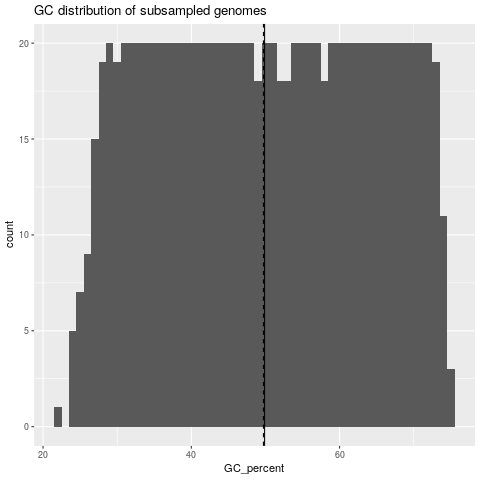

In [7]:
%%R

norm.sam.genomes = data.frame()
subs.genome.stats$GC_group = round(subs.genome.stats$GC_percent)

for (group in unique(subs.genome.stats$GC_group)){
    sub.df = subs.genome.stats[subs.genome.stats$GC_group == group,]
    if (nrow(sub.df) > 20){
        set.seed(7242)
        sub.df = sample_n(sub.df, 20)
    }
    norm.sam.genomes = rbind(norm.sam.genomes, sub.df)
}

norm.sam.genomes.plot = ggplot(data=norm.sam.genomes, aes(x=GC_percent)) +
    geom_histogram(binwidth=1) +
    geom_vline(xintercept = mean(norm.sam.genomes$GC_percent)) +
    geom_vline(xintercept = median(norm.sam.genomes$GC_percent), linetype=2) +
    ggtitle(label="GC distribution of subsampled genomes")

subs.genome.stats.dist = norm.sam.genomes %>%
    mutate(dist40 = abs(GC_percent-40),
           dist50 = abs(GC_percent-50),
           dist60 = abs(GC_percent-60)) %>%
    mutate(dist40 = max(dist40) - dist40 + 1, 
           dist50 = max(dist50) - dist50 + 1, 
           dist60 = max(dist60) - dist60 + 1)

print(nrow(norm.sam.genomes))
print(head(subs.genome.stats.dist))
print(norm.sam.genomes.plot)

### Sample reference sets

Now I'll sample the references to get the three reference sets, weighting each genome by its distance to the target G+C for that set (40%, 50%, and 60%).

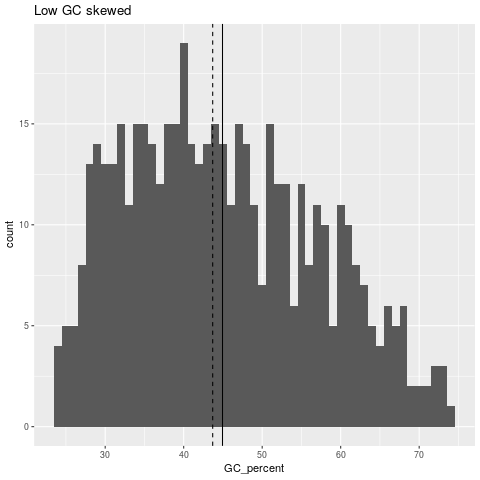

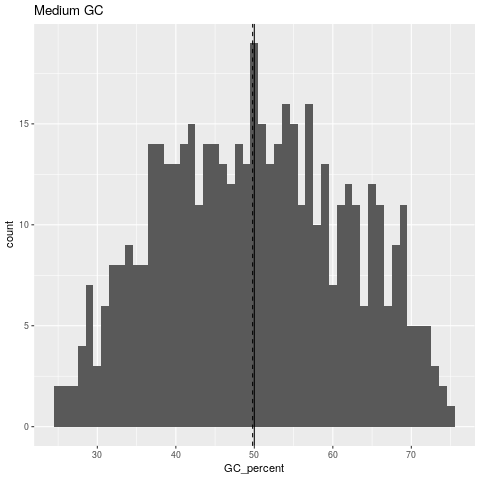

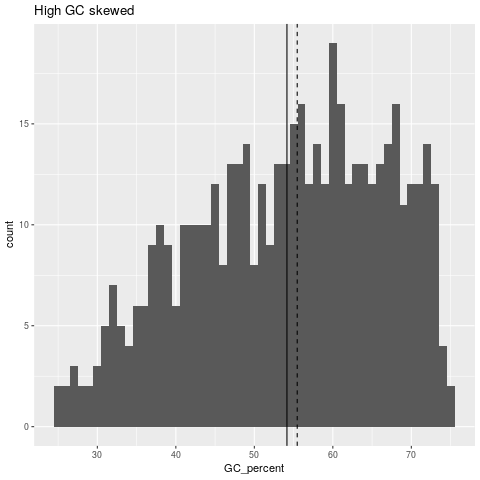

In [8]:
%%R
set.seed(7242)
sam40 = sample(seq_len(nrow(subs.genome.stats.dist)), prob = subs.genome.stats.dist$dist40, size=500, replace = FALSE)
sam40 = subs.genome.stats.dist[sam40,] %>%
    select(-GC_group, -dist40, -dist50, -dist60)

set.seed(7242)
sam50 = sample(seq_len(nrow(subs.genome.stats.dist)), prob = subs.genome.stats.dist$dist50, size=500, replace = FALSE)
sam50 = subs.genome.stats.dist[sam50,] %>%
    select(-GC_group, -dist40, -dist50, -dist60)

set.seed(7242)
sam60 = sample(seq_len(nrow(subs.genome.stats.dist)), prob = subs.genome.stats.dist$dist60, size=500, replace = FALSE)
sam60 = subs.genome.stats.dist[sam60,] %>%
    select(-GC_group, -dist40, -dist50, -dist60)


sam40.plot = ggplot(data=sam40, aes(x=GC_percent)) +
    geom_histogram(binwidth=1) +
    geom_vline(xintercept = mean(sam40$GC_percent)) +
    geom_vline(xintercept = median(sam40$GC_percent), linetype=2) +
    ggtitle(label="Low GC skewed")

sam50.plot = ggplot(data=sam50, aes(x=GC_percent)) +
    geom_histogram(binwidth=1) +
    geom_vline(xintercept = mean(sam50$GC_percent)) +
    geom_vline(xintercept = median(sam50$GC_percent), linetype=2) +
    ggtitle(label="Medium GC")

sam60.plot = ggplot(data=sam60, aes(x=GC_percent)) +
    geom_histogram(binwidth=1) +
    geom_vline(xintercept = mean(sam60$GC_percent)) +
    geom_vline(xintercept = median(sam60$GC_percent), linetype=2) +
    ggtitle(label="High GC skewed")

print(sam40.plot)
print(sam50.plot)
print(sam60.plot)


## 3) Save data

In [9]:
%%R
write.table(sam40, file="low_GC_skew_genomes.txt", sep="\t", quote=FALSE, row.names=FALSE, col.names=TRUE)
write.table(sam50, file="medium_GC_genomes.txt", sep="\t", quote=FALSE, row.names=FALSE, col.names=TRUE)
write.table(sam60, file="high_GC_skew_genomes.txt", sep="\t", quote=FALSE, row.names=FALSE, col.names=TRUE)